## Sentiment analysis using pyspark

In [1]:
from IPython import display
import math
import pyspark
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import HiveContext
from pyspark.sql.functions import *
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

### Create Spark Context and load dataset

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sqlContext=HiveContext(sc)

C:\Users\Avinash\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:733: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  warnings.warn(
C:\Users\Avinash\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
customSchema = StructType([
    StructField("category", StringType()), 
    StructField("clean_text", StringType())])


In [4]:
filename1 = 'train.csv'

In [5]:
df1 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename1)
#df1.count()
df=df1

In [6]:
print(df1.count())

3600000


In [7]:
#df.count() 

In [ ]:
data = df.na.drop(how='any')
data.show(5)

In [ ]:
#df.count() 

In [ ]:
data.printSchema()

## Preprocessing

In [19]:
from pyspark.sql.functions import col

#data.groupBy("category").count().orderBy(col("count").desc()).show()

## Model Pipeline

In [85]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
import nltk
from nltk.corpus import stopwords
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="clean_text", outputCol="words", pattern="\\W")

# stop words
#add_stopwords = [ "a", "an","in", "on","the","I", "you", "he", "she", "it", "we", "they", "me", "him", "her", "us", "them"] 
add_stopwords = set(stopwords.words('english'))

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(list(add_stopwords))


countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=30000, minDF=5)

In [81]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])


pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
#dataset.show(5)

In [82]:
dataset.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+-----+
|category|          clean_text|               words|            filtered|            features|label|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
|       2|Stuning even for ...|[stuning, even, f...|[stuning, even, f...|(30000,[0,1,2,3,4...|  1.0|
|       2|The best soundtra...|[the, best, sound...|[best, soundtrack...|(30000,[0,1,2,3,4...|  1.0|
|       2|"Amazing!. This s...|[amazing, this, s...|[amazing, this, s...|(30000,[1,2,3,5,6...|  1.0|
|       2|Excellent Soundtr...|[excellent, sound...|[excellent, sound...|(30000,[0,1,2,4,5...|  1.0|
|       2|Remember, Pull Yo...|[remember, pull, ...|[remember, pull, ...|(30000,[1,2,4,5,6...|  1.0|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [22]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
#print("Training Dataset Count: " + str(trainingData.count()))
#print("Test Dataset Count: " + str(testData.count()))

Logistic Regression


In [23]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|This is what i think of GC....|       1|[0.9999999999999998,2.22044...|  0.0|       0.0|
|No Good!. Stinks! Stinks! S...|       1|[0.9999999999989759,1.02406...|  0.0|       0.0|
|No. No no no no no no no no...|       1|[0.9999999976492999,2.35070...|  0.0|       0.0|
|Bad Bad Bad Bad Bad Bad Bad...|       1|[0.9999999974275748,2.57242...|  0.0|       0.0|
|The Illustrated Man-. It wa...|       1|[0.9999999851147299,1.48852...|  0.0|       0.0|
|Ew. TRASH TRASH TRASH TRASH...|       1|[0.9999999848757495,1.51242...|  0.0|       0.0|
|Horrible. Horrible, Es una ...|       1|[0.9999999673141169,3.26858...|  0.0|       0.0|
|Word Wealth. This book stin...|       1|[0.9999999662677757,3.37322...|  0.0|       0.0|
|Spit!!!!!

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.894948182403883


Model Summary


In [25]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.09274251154816895
label 1: 0.11228863996343356

True positive rate by label:
label 0: 0.8877113600365665
label 1: 0.9072574884518311

Precision by label:
label 0: 0.9054243601272016
label 1: 0.8898460446226937

Recall by label:
label 0: 0.8877113600365665
label 1: 0.9072574884518311

F-measure by label:
label 0: 0.8964803735718886
label 1: 0.8984674201513597

Accuracy: 0.8974835245417664

FPR: 0.10251467605336892

TPR: 0.8974835245417664

F-measure: 0.8974738053984657

Precision: 0.8976359194401411

Recall: 0.8974835245417664


## Logistic Regression using TF-IDF Features

In [26]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=30000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|This is what i think of GC....|       1|[0.9999999999999998,2.22044...|  0.0|       0.0|
|No Good!. Stinks! Stinks! S...|       1|[0.9999999999995814,4.18554...|  0.0|       0.0|
|Bad Bad Bad Bad Bad Bad Bad...|       1|[0.9999999992269233,7.73076...|  0.0|       0.0|
|No. No no no no no no no no...|       1|[0.9999999991115656,8.88434...|  0.0|       0.0|
|Horrible. Horrible, Es una ...|       1|[0.9999999859591506,1.40408...|  0.0|       0.0|
|Word Wealth. This book stin...|       1|[0.9999999812306982,1.87693...|  0.0|       0.0|
|Spit!!!!!!!. This album is ...|       1|[0.999999523906822,4.760931...|  0.0|       0.0|
|The Illustrated Man-. It wa...|       1|[0.9999982025354847,1.79746...|  0.0|       0.0|
|Zzzzzzzzz

In [129]:
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("category", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|!!! GOOD, BUT.................|       2|[0.5017646464206011,0.49823...|  1.0|       0.0|
|""" Almost ""perfect. I onl...|       2|[0.5002191015510651,0.49978...|  1.0|       0.0|
|"""BAD A**"". I got this er...|       2|[0.5020516302494911,0.49794...|  1.0|       0.0|
|"1st class book on how to u...|       2|[0.5122942383456983,0.48770...|  1.0|       0.0|
|!!!. First things first, Co...|       2|[0.5236269912715589,0.47637...|  1.0|       0.0|
|"""A DEFINITE KEEPER"". Thi...|       2|[0.5074305972022748,0.49256...|  1.0|       0.0|
|"1ST OF ALL SHANNON HOLMES ...|       2|[0.5176967184143518,0.48230...|  1.0|       0.0|
|"""Dancing Machine"" a Smok...|       2|[0.502013316418735,0.497986...|  1.0|       0.0|
|"""Clear 

In [49]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8850189164021753

### DecisionTreeClassifier

In [52]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|"""Lost"". What is J J Abra...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"A call to arms rather than...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"280 pages I'll never get b...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"An Insult to the Artists a...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"""SOME BEACH IS THE ONLY G...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"A complete waste of money!...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"A Waste of Money, Time & E...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"A book about nothing!. Thi...|       1|[0.9732403187836116,0.02675...|  0.0|       0.0|
|"""The La

In [53]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy) 

0.6554911468582181


## Random Forest

In [54]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|Don't waste your money!. Th...|       1|[0.6025500554340077,0.39744...|  0.0|       0.0|
|"Only thing worse than the ...|       1|[0.6019055302136251,0.39809...|  0.0|       0.0|
|Boring and Long Winded. I w...|       1|[0.6004379054591535,0.39956...|  0.0|       0.0|
|UPDATE: It gets worse. Afte...|       1|[0.5999237499115319,0.40007...|  0.0|       0.0|
|"Horrible move, horrible re...|       1|[0.5980430818170858,0.40195...|  0.0|       0.0|
|BAD IS ONLY ONE WAY TO DESC...|       1|[0.5968772999800105,0.40312...|  0.0|       0.0|
|Don't buy it; if bought, re...|       1|[0.5954257584308066,0.40457...|  0.0|       0.0|
|Defective ... Junk ... Buye...|       1|[0.5943201948076569,0.40567...|  0.0|       0.0|
|Terrible 

In [55]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy) 

0.7740130341097058


## Visualization

In [58]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Random Forest',"Decision Tree" ]
accuracy = [lrAccuracy,rfAccuracy,dtAccuracy]

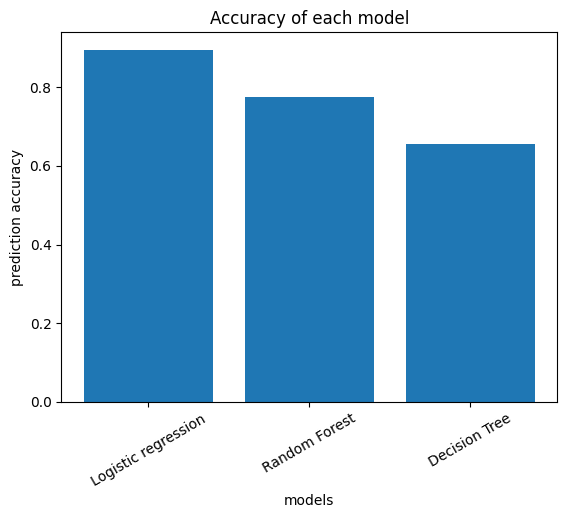

In [59]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()